In [1]:

import os, json, time
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score, confusion_matrix, ConfusionMatrixDisplay,
                             classification_report)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA

SEED = 42
np.random.seed(SEED)

DATA_PATH = "sample_2e7_design_precessing_higherordermodes_3detectors.h5"

USE_SUBSAMPLE = True
SUBSAMPLE_N = 100_000


# Feature list (no snr)
FEATURES = [
    "mtot","q","z",
    "chi1x","chi1y","chi1z","chi2x","chi2y","chi2z",
    "iota","ra","dec","psi"
]
LABEL = "det"

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["axes.grid"] = True


## Load data 

In [2]:
with h5py.File(DATA_PATH, "r") as h5:
    data = {k: np.array(h5[k][:]) for k in FEATURES + [LABEL]}

df = pd.DataFrame(data)
if USE_SUBSAMPLE and len(df) > SUBSAMPLE_N:
    df = df.sample(n=SUBSAMPLE_N, random_state=SEED).reset_index(drop=True)

print(df.head())
print(f"Samples: {len(df):,} | Positive rate (det=1): {df[LABEL].mean():.3f}")


         mtot         q         z     chi1x     chi1y     chi1z     chi2x  \
0  215.841084  0.652398  3.780898 -0.242688 -0.105370  0.220559  0.498129   
1  123.861946  0.785090  2.208192  0.091138  0.289774 -0.785125 -0.030110   
2  503.419949  0.659002  0.059055 -0.226171  0.546152  0.487965 -0.125629   
3  876.481232  0.279340  3.932291  0.220019  0.186074  0.130978  0.668477   
4  718.182417  0.775806  1.616687 -0.054865  0.039857  0.002438  0.398033   

      chi2y     chi2z      iota        ra       dec       psi  det  
0  0.013985 -0.261727  1.671670 -0.074483 -0.100995  2.750428    0  
1 -0.000565  0.314354  0.793970  1.390378 -0.625001  2.843098    0  
2 -0.213720  0.408392  2.738049 -0.589392  0.167969  2.353275    1  
3 -0.065973 -0.059706  1.159821  0.327359  0.764438  1.196103    0  
4  0.483840  0.383837  1.109524 -2.959737 -0.793640  2.091958    0  
Samples: 100,000 | Positive rate (det=1): 0.144


## Scaling 

In [3]:

# Physics Limits 
LIMITS = {
    'mtot'  : (2, 1000),
    'q'     : (0.1, 1),
    'z'     : (1e-4, 4),
    'chi1x' : (-1, 1), 'chi1y' : (-1, 1), 'chi1z' : (-1, 1),
    'chi2x' : (-1, 1), 'chi2y' : (-1, 1), 'chi2z' : (-1, 1),
    'iota'  : (0, np.pi),
    'ra'    : (-np.pi, np.pi),
    'dec'   : (-np.pi/2, np.pi/2),
    'psi'   : (0, np.pi)
}

#Scale [-1,1] for equity of feautures and activation functions (vanishing gradients)
def scale_pm1(Xdf: pd.DataFrame, features=FEATURES) -> np.ndarray:
    Xs = []
    for f in features:
        lo, hi = LIMITS[f]
        Xs.append(1 - 2*((Xdf[f].values - lo)/(hi - lo)))
    return np.vstack(Xs).T

X = df[FEATURES].copy()
y = df[LABEL].astype(int).values

# Split train/test set
X_trv, X_test, y_trv, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=SEED)

#Scale using physics-informed limits 
X_trv_s = scale_pm1(pd.DataFrame(X_trv, columns=FEATURES))
X_test_s = scale_pm1(pd.DataFrame(X_test, columns=FEATURES))

print("Scaled shapes:", X_trv_s.shape, X_test_s.shape)


Scaled shapes: (80000, 13) (20000, 13)


## Cross-validation and hyperparameter optimization (based on ROC AUC)

In [4]:
# Base estimator
mlp = MLPClassifier(max_iter=1000, early_stopping=True, random_state=SEED) #feed-forward fully-connected nn

# Hyperparameter grid (4x2x3x3x3=216)
param_grid = {
    "hidden_layer_sizes": [(128,64), (128,128), (256,128), (64,64,32)],
    "activation": ["tanh", "relu"],
    "alpha": [1e-6, 1e-5, 1e-4],     #L2 regularization (lower->more free, but overfitting)
    "learning_rate_init": [5e-4, 1e-3, 2e-3], #higher->faster, but risk of divergences
    "batch_size": [256, 512, 1024] #samples used in a single updating of weight (bigger->less updating)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

#n of fit: 216*3=648
grid = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring="roc_auc",
    n_jobs=-1,      # use all CPU cores
    cv=cv,
    verbose=2,
    refit=True
)

grid.fit(X_trv_s, y_trv)
print("Best CV ROC AUC:", grid.best_score_)
print("Best params:\n", json.dumps(grid.best_params_, indent=2))


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best CV ROC AUC: 0.9973951893159761
Best params:
 {
  "activation": "tanh",
  "alpha": 0.0001,
  "batch_size": 256,
  "hidden_layer_sizes": [
    256,
    128
  ],
  "learning_rate_init": 0.0005
}


## Train best model on train+val and evaluate on the test set

Test ROC AUC: 0.9973 | Test PR AUC (AP): 0.9843
              precision    recall  f1-score   support

           0     0.9892    0.9870    0.9881     17122
           1     0.9235    0.9357    0.9296      2878

    accuracy                         0.9796     20000
   macro avg     0.9563    0.9613    0.9588     20000
weighted avg     0.9797    0.9796    0.9797     20000



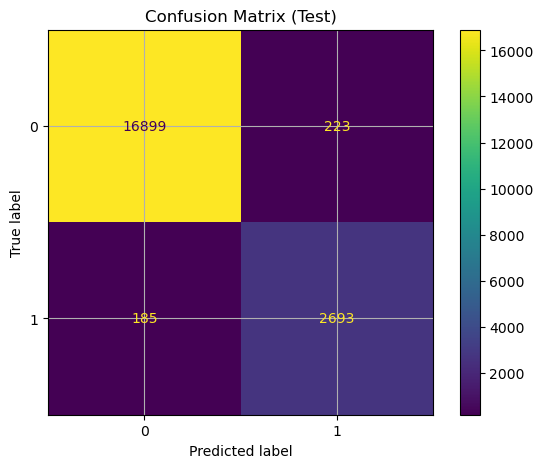

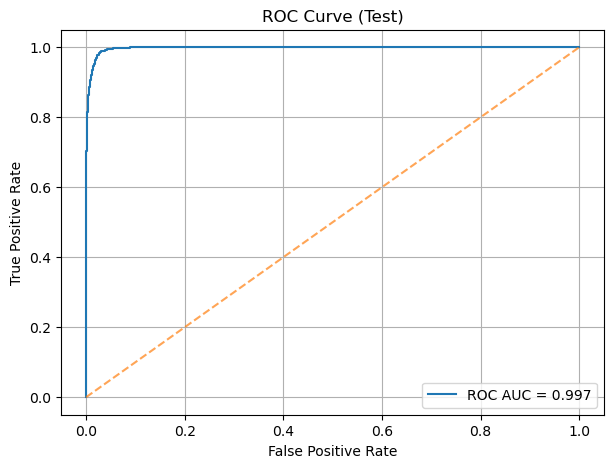

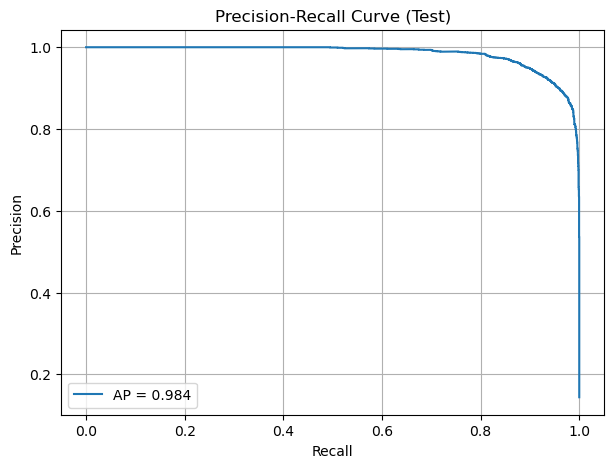

In [5]:
#Train best model
best_mlp = grid.best_estimator_
best_mlp.fit(X_trv_s, y_trv)

# Predict on test set
proba_test = best_mlp.predict_proba(X_test_s)[:,1]
pred_test = (proba_test >= 0.5).astype(int)

#Metrics
roc_auc = roc_auc_score(y_test, proba_test)
ap = average_precision_score(y_test, proba_test)

print(f"Test ROC AUC: {roc_auc:.4f} | Test PR AUC (AP): {ap:.4f}")
print(classification_report(y_test, pred_test, digits=4))

#Confusion matrix
cm = confusion_matrix(y_test, pred_test)
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(values_format="d")
plt.title("Confusion Matrix (Test)"); plt.show()

# ROC curve
fpr, tpr, thr = roc_curve(y_test, proba_test)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',alpha=0.7)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend()
plt.title("ROC Curve (Test)"); plt.show()

#Precision-Recall curve
prec, rec, thr_pr = precision_recall_curve(y_test, proba_test)
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.title("Precision-Recall Curve (Test)"); plt.show()
